In [1]:
import numpy as np
HORIZONTAL_MAX = 228000
#HORIZONTAL_MAX = 220000
#HORIZONTAL_MAX = 205000
VERTICAL_MAX = 228000
#VERTICAL_MAX = 220000
#VERTICAL_MAX = 205000
LENGTH_MAX = 32767
LENGTH_MAX_VALUE_MM = 1830 # without offset

LENGTH_V_OFFSET = 8530

LENGTH_OFFSET = 155+35+2

HEIGHT_OFFSET = 0

ll = np.arange(0,2100,100)+ LENGTH_OFFSET
#fll = np.array([
#    8527,9137,9759,10429,11082,11751,12406,13088,13763,14456,15095,
#    15785,16422,17132,17802,18443,19126,19784,20479,21122,
#    21787,22484,23110,23789,24455,25109,25771,26493,27117,27792,
#    28446,29146,29813,30477,31137,31804,32472
#])-(8527-659)
fll = np.array([
    1609,2904,4247,5584,6906,
    8274,9595,10918,
    12255,13643,14934,
    16269,17607,18966,
    20315,21638,22960,
    24299,25652,26960,
    28298
])

res = np.polyfit(fll,ll,1)
p = np.poly1d(res)

def convert_to_xyz(h, v, l):
    # Normalize h and v to radians between 0 and 2π using numpy
    h_angle = (h % HORIZONTAL_MAX) * (2 * np.pi / HORIZONTAL_MAX)
    v_angle = (v % VERTICAL_MAX) * (2 * np.pi / VERTICAL_MAX)

    v_angle += np.pi/2
    # Compute the radial distance r
    #r = (l - LENGTH_V_OFFSET)*(LENGTH_MAX_VALUE_MM/ (LENGTH_MAX-LENGTH_V_OFFSET)) + LENGTH_OFFSET
    r = p(l)
    # Convert spherical to Cartesian coordinates
    x = r * np.sin(v_angle) * np.cos(h_angle)
    y = r * np.sin(v_angle) * np.sin(h_angle)
    z = r * np.cos(v_angle)
    

    return x, y, z



def rigid_transform_3D(A, B):
    """
    Find the optimal rotation and translation that aligns points A to points B.
    
    A: Nx3 numpy array of points in the first coordinate system.
    B: Nx3 numpy array of points in the second coordinate system.
    
    Returns: 
    R: Rotation matrix (3x3)
    t: Translation vector (3x1)
    """
    assert A.shape == B.shape

    # Step 1: Compute the centroids of both sets
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)

    # Step 2: Center the points
    AA = A - centroid_A
    BB = B - centroid_B

    # Step 3: Compute the covariance matrix
    H = np.dot(AA.T, BB)

    # Step 4: Compute the Singular Value Decomposition
    U, S, Vt = np.linalg.svd(H)

    # Step 5: Compute the rotation matrix R
    R = np.dot(Vt.T, U.T)

    # Special reflection case
    if np.linalg.det(R) < 0:
        Vt[2, :] *= -1
        R = np.dot(Vt.T, U.T)

    # Step 6: Compute the translation vector t
    t = centroid_B.T - np.dot(R, centroid_A.T)

    return R, t


def find_transformation(points_A, points_B):
    # Center the points
    centroid_A = np.mean(points_A, axis=0)
    centroid_B = np.mean(points_B, axis=0)
    A_centered = points_A - centroid_A
    B_centered = points_B - centroid_B
    
    # Compute the covariance matrix
    H = np.dot(A_centered.T, B_centered)
    
    # Perform SVD
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)
    
    # Ensure a right-handed coordinate system (det(R) should be 1)
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = np.dot(Vt.T, U.T)
    
    # Calculate translation
    t = centroid_B - np.dot(R, centroid_A)
    
    return R, t

In [2]:
import requests
import numpy as np
import matplotlib.pyplot as plt

sections = requests.get("http://localhost:8000/data/get-dummysections").json()

# get calpoint l from base 1
cal_l_from_1 = []
for section in sections[-40:]:
    if len(section.get("points")) == 4:
        if section.get("name").find("calpoints-l") == 0:
            points = section.get("points")
            point_disp = []
            for point in points:
                h = point.get("h")
                v = point.get("v")
                l = point.get("l")
                point_disp.append([h,v,l])
            cal_l_from_1.append(point_disp)
cal_l_from_1_arr = np.array(cal_l_from_1)

# get calpoint r from base 1
cal_r_from_1 = []
for section in sections[-40:]:
    if len(section.get("points")) == 4:
        if section.get("name").find("calpoints-r") == 0:
            points = section.get("points")
            point_disp = []
            for point in points:
                h = point.get("h")
                v = point.get("v")
                l = point.get("l")
                point_disp.append([h,v,l])
            cal_r_from_1.append(point_disp)
cal_r_from_1_arr = np.array(cal_r_from_1)

# get calpoint l from base 2
cal_l_from_2 = []
for section in sections[-40:]:
    if len(section.get("points")) == 4:
        if section.get("name").find("calpoints-c-l") == 0:
            points = section.get("points")
            point_disp = []
            for point in points:
                h = point.get("h")
                v = point.get("v")
                l = point.get("l")
                point_disp.append([h,v,l])
            cal_l_from_2.append(point_disp)
cal_l_from_2_arr = np.array(cal_l_from_2)

# get calpoint r from base 2
cal_r_from_2 = []
for section in sections[-40:]:
    if len(section.get("points")) == 4:
        if section.get("name").find("calpoints-c-r") == 0:
            points = section.get("points")
            point_disp = []
            for point in points:
                h = point.get("h")
                v = point.get("v")
                l = point.get("l")
                point_disp.append([h,v,l])
            cal_r_from_2.append(point_disp)
cal_r_from_2_arr = np.array(cal_r_from_2)

# get meas l from base 1
meas_l_from_1 = []
for section in sections[-40:]:
    if len(section.get("points")) == 7:
        if section.get("name").find("measpoints-l") == 0:
            points = section.get("points")
            point_disp = []
            for point in points:
                h = point.get("h")
                v = point.get("v")
                l = point.get("l")
                point_disp.append([h,v,l])
            meas_l_from_1.append(point_disp)
meas_l_from_1_arr = np.array(meas_l_from_1)

# get meas r from base 1
meas_r_from_1 = []
for section in sections[-40:]:
    if len(section.get("points")) == 7:
        if section.get("name").find("measpoints-r") == 0:
            points = section.get("points")
            point_disp = []
            for point in points:
                h = point.get("h")
                v = point.get("v")
                l = point.get("l")
                point_disp.append([h,v,l])
            meas_r_from_1.append(point_disp)
meas_r_from_1_arr = np.array(meas_r_from_1)

# get meas l from base 2 
meas_l_from_2 = []
for section in sections[-40:]:
    if len(section.get("points")) == 7:
        if section.get("name").find("measpoints-c-l") == 0:
            points = section.get("points")
            point_disp = []
            for point in points:
                h = point.get("h")
                v = point.get("v")
                l = point.get("l")
                point_disp.append([h,v,l])
            meas_l_from_2.append(point_disp)
meas_l_from_2_arr = np.array(meas_l_from_2)

# get meas r from base 2
meas_r_from_2 = []
for section in sections[-40:]:
    if len(section.get("points")) == 7:
        if section.get("name").find("measpoints-c-r") == 0:
            points = section.get("points")
            point_disp = []
            for point in points:
                h = point.get("h")
                v = point.get("v")
                l = point.get("l")
                point_disp.append([h,v,l])
            meas_r_from_2.append(point_disp)
meas_r_from_2_arr = np.array(meas_r_from_2)

In [3]:
cal_from_1 = (np.mean(cal_l_from_1_arr, axis=0) + np.mean(cal_r_from_1_arr, axis=0))/2
cal_from_2 = (np.mean(cal_l_from_2_arr, axis=0) + np.mean(cal_r_from_2_arr, axis=0))/2

meas_from_1 = (np.mean(meas_l_from_1_arr, axis=0) + np.mean(meas_r_from_1_arr, axis=0))/2
meas_from_2 = (np.mean(meas_l_from_2_arr, axis=0) + np.mean(meas_r_from_2_arr, axis=0))/2

cal_from_1 = (np.mean(cal_l_from_1_arr, axis=0) )
cal_from_2 = (np.mean(cal_l_from_2_arr, axis=0) )

meas_from_1 = (np.mean(meas_l_from_1_arr, axis=0))
meas_from_2 = (np.mean(meas_l_from_2_arr, axis=0))

c:\Users\ACSG\Documents\Python Scripts\felmero_python\.venv\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ACSG\Documents\Python Scripts\felmero_python\.venv\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [4]:
cartesian_tmp = []
for h,v,l in cal_from_1:
    cartesian_tmp.append(convert_to_xyz(h,v,l))
cal_from_1_cart = np.array(cartesian_tmp)

cartesian_tmp = []
for h,v,l in cal_from_2:
    cartesian_tmp.append(convert_to_xyz(h,v,l))
cal_from_2_cart = np.array(cartesian_tmp)

cartesian_tmp = []
for h,v,l in meas_from_1:
    cartesian_tmp.append(convert_to_xyz(h,v,l))
meas_from_1_cart = np.array(cartesian_tmp)

cartesian_tmp = []
for h,v,l in meas_from_2:
    cartesian_tmp.append(convert_to_xyz(h,v,l))
meas_from_2_cart = np.array(cartesian_tmp)


TypeError: 'numpy.float64' object is not iterable

In [ ]:
print(cal_from_1_cart)
print(cal_from_2_cart)
print(meas_from_2_cart)
print(meas_from_1_cart)

[[  89.86169696  841.54477225 -198.65231023]
 [  27.60119432  841.21523777 -198.86064202]
 [  27.50593671  920.49815864 -198.05409959]
 [  27.69552145  999.34281514 -197.86719919]]
[[ 211.46422964  906.9319214  -201.59597849]
 [ 258.43307565  867.67667007 -202.1748524 ]
 [ 205.21975534  809.12007686 -202.66732382]
 [ 151.27293401  749.01562061 -203.55009033]]
[[  95.2952339   689.24365006 -203.61541091]
 [  40.62879845  629.44339747 -204.59350341]
 [ -14.12432215  566.84498072 -204.69628167]
 [ 101.34542858  786.96606463 -202.57964567]
 [  47.72520958  728.91546087 -204.20218075]
 [  -7.00450728  669.29708344 -204.69804988]
 [ -61.90377902  606.99105503 -204.92290835]]
[[  25.57597581 1083.50243157 -198.1291618 ]
 [  25.39899232 1161.4755086  -197.97147341]
 [  25.56782135 1242.17582292 -196.70577969]
 [  86.92204322 1001.74737446 -199.46716122]
 [  86.72694939 1083.11688942 -198.736263  ]
 [  86.43448983 1161.75917327 -198.1562764 ]
 [  86.49004069 1241.35511425 -196.21629641]]


In [ ]:

cal_from_1_cart[:,2] = np.mean(cal_from_1_cart[:,2])
cal_from_2_cart[:,2] = np.mean(cal_from_2_cart[:,2])
meas_from_1_cart[:,2] = np.mean(meas_from_1_cart[:,2])
meas_from_2_cart[:,2] = np.mean(meas_from_2_cart[:,2])

points_from_1 = np.vstack((cal_from_1_cart,meas_from_1_cart))
points_from_2 = np.vstack((cal_from_2_cart, meas_from_2_cart))

R,t = rigid_transform_3D(points_from_1,points_from_2)
#R,t = find_transformation(points_from_1[:3],points_from_2[:3])

transformed_meas_from_2 = np.dot(points_from_2, R.T) + t

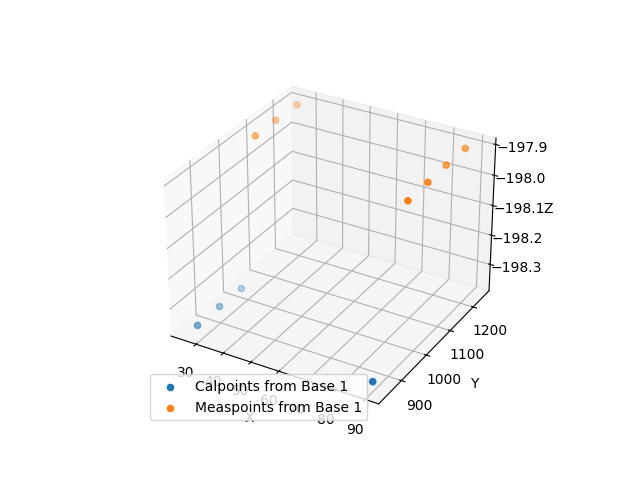

In [ ]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(cal_from_1_cart[:, 0],cal_from_1_cart[:, 1], cal_from_1_cart[:, 2], 'bo-', label="Calpoints from Base 1")
ax.scatter(meas_from_1_cart[:, 0],meas_from_1_cart[:, 1], meas_from_1_cart[:, 2], 'ro-', label="Measpoints from Base 1")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()

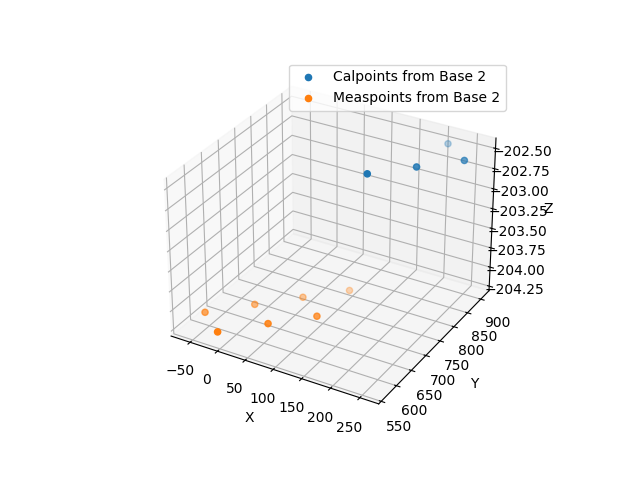

In [ ]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(cal_from_2_cart[:, 0],cal_from_2_cart[:, 1], cal_from_2_cart[:, 2], 'bo-', label="Calpoints from Base 2")
ax.scatter(meas_from_2_cart[:, 0],meas_from_2_cart[:, 1], meas_from_2_cart[:, 2], 'ro-', label="Measpoints from Base 2")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

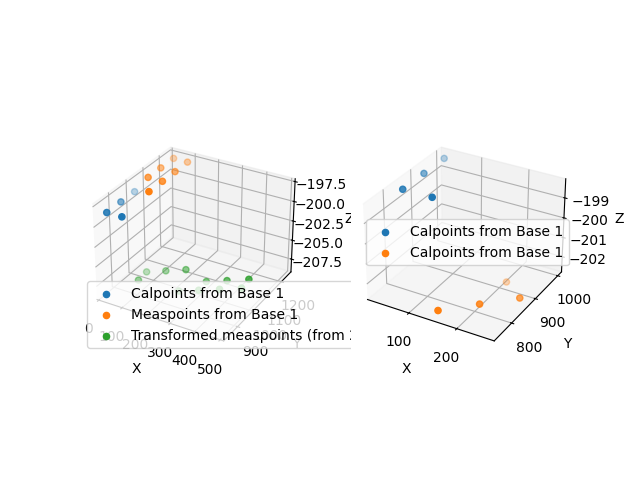

In [ ]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')

ax.scatter(cal_from_1_cart[:, 0],cal_from_1_cart[:, 1], cal_from_1_cart[:, 2], 'bo-', label="Calpoints from Base 1")
ax.scatter(meas_from_1_cart[:, 0],meas_from_1_cart[:, 1], meas_from_1_cart[:, 2], 'ro-', label="Measpoints from Base 1")
ax.scatter(transformed_meas_from_2[:, 0],transformed_meas_from_2[:, 1], transformed_meas_from_2[:, 2], 'go-', label="Transformed measpoints (from 2 to 1)")



ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
ax1 = fig.add_subplot(122, projection='3d')

ax1.scatter(cal_from_1_cart[:, 0],cal_from_1_cart[:, 1], cal_from_1_cart[:, 2], 'bo-', label="Calpoints from Base 1")
ax1.scatter(cal_from_2_cart[:, 0],cal_from_2_cart[:, 1], cal_from_2_cart[:, 2], 'bo-', label="Calpoints from Base 1")

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()
plt.show()

In [ ]:
# using Kabsch 
np.linalg.norm(np.diff(cal_from_1_cart,axis=0), axis=1)

array([62.26137471, 79.28297809, 78.84488444])

In [ ]:
np.linalg.norm(np.diff(cal_from_2_cart,axis=0), axis=1)

array([61.21312973, 79.12352411, 80.76388545])

In [ ]:
np.linalg.norm(np.diff(meas_from_1_cart,axis=0), axis=1)

array([ 77.97327788,  80.70049092, 248.13339028,  81.36974885,
        78.64282765,  79.59596036])

In [ ]:
np.linalg.norm(np.diff(meas_from_2_cart,axis=0), axis=1)

array([ 81.02153649,  83.16529321, 248.56901439,  79.02531546,
        80.93017258,  83.04198464])

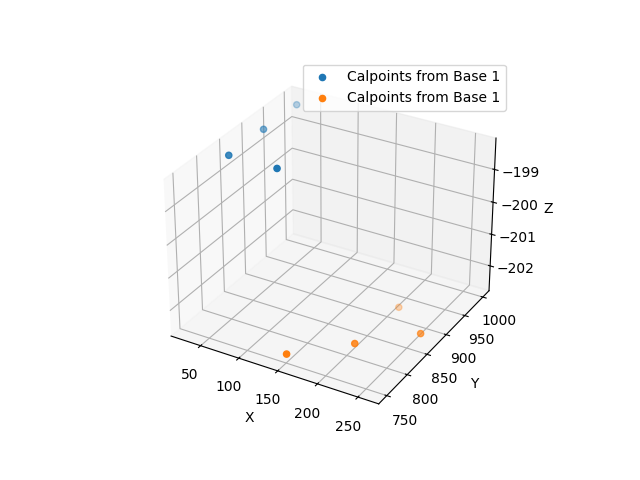

In [ ]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(cal_from_1_cart[:, 0],cal_from_1_cart[:, 1], cal_from_1_cart[:, 2], 'bo-', label="Calpoints from Base 1")
ax.scatter(cal_from_2_cart[:, 0],cal_from_2_cart[:, 1], cal_from_2_cart[:, 2], 'bo-', label="Calpoints from Base 1")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

In [ ]:
np.sqrt(np.sum(np.diff(cal_from_1, axis=0)[2]**2))

np.float64(1193.9359111778144)